# Part I
## 1-3

Users
------------------

Entries by column: 
BrukerID    6040
Kjonn       6040
Alder       6040
Jobb        6040
Postkode    6040
dtype: int64



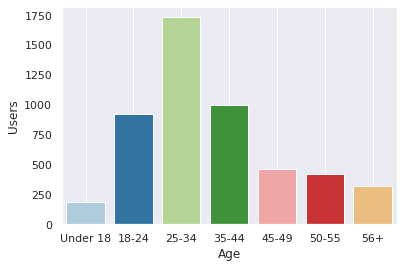

/home/elias/miniconda3/envs/pythonProject/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/elias/miniconda3/envs/pythonProject/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


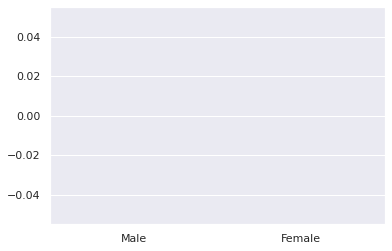

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [ ]:
sns.set_theme(style="darkgrid",palette="Paired")

user_df = pd.read_csv ('clean_data/bruker.csv')
movies_df = pd.read_csv ('clean_data/film.csv')
rank_df = pd.read_csv ('clean_data/rangering.csv')

print("Users")
print("------------------\n")
print("Entries by column: ")
print(pd.isnull(user_df).count())
print()

user_count= user_df["Alder"].value_counts()
groups_int= [1,18,25,35,45,50,56]
groups = ["Under 18","18-24","25-34","35-44","45-49","50-55","56+"]
values = [user_count[x] for x in groups_int]
sns.barplot(x=groups,y=values)
plt.grid()
plt.xlabel("Age")
plt.ylabel("Users")
plt.show()

plt.figure(2)

sns.barplot(x=["Male","Female"],y=[user_df["BrukerID"][(user_df['Kjonn'] == "M")].count(), user_df["BrukerID"][(user_df['Kjonn'] == "F")].count()])
plt.show()

Movies
------------------

Entries by column: 
FilmID         3883
Tittel         3883
Aar            3883
Action         3883
Adventure      3883
Animation      3883
Children's     3883
Comedy         3883
Crime          3883
Documentary    3883
Drama          3883
Fantasy        3883
Film-Noir      3883
Horror         3883
Musical        3883
Mystery        3883
Romance        3883
Sci-Fi         3883
Thriller       3883
War            3883
Western        3883
dtype: int64



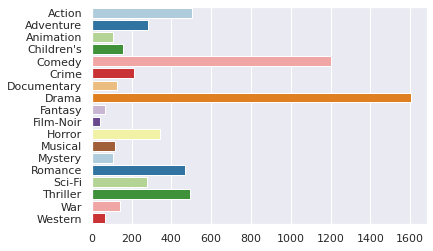

In [95]:
print("Movies")
print("------------------\n")
print("Entries by column: ")
print(pd.isnull(movies_df).count())
print()

categories = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
categories_count = [movies_df[x].value_counts()[1] for x in categories]

sns.barplot(y=categories, x=categories_count, orient='h',palette="Paired")
plt.show()

In [96]:
print("Rankings")
print("------------------\n")
print("Entries by column: ")
print(pd.isnull(rank_df).count())
print()
sns.set_theme(style="darkgrid")
sns.set_palette(palette="Paired")

rank_df['Tidstempel'] = pd.to_datetime(rank_df['Tidstempel'],unit='s')
movie_count = rank_df["FilmID"].value_counts()

Rankings
------------------

Entries by column: 
BrukerID      900188
FilmID        900188
Rangering     900188
Tidstempel    900188
dtype: int64



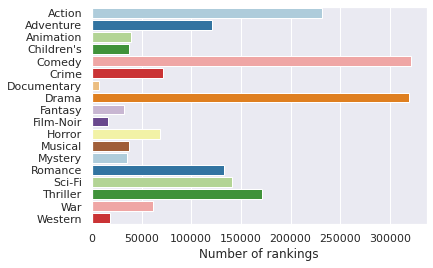

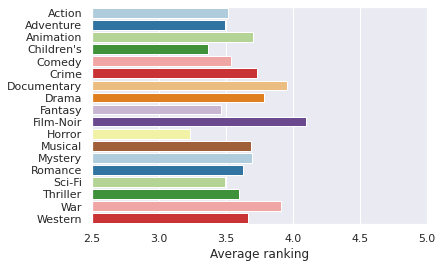

In [97]:
sns.set_theme(style="darkgrid")
sns.set_palette(palette="Paired")

result_df = pd.merge(movies_df, rank_df)

categories = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
result_count = [result_df[x].value_counts()[1] for x in categories]

sns.color_palette("Paired")
#sns.jointplot(y=categories,x=result_count,hue=categories)
sns.barplot(y=categories,x=result_count,orient='h',palette="Paired")
plt.xlabel("Number of rankings")
plt.show()

plt.figure(2)
result_mean= [result_df[result_df[x]==1]["Rangering"].mean() for x in categories]
sns.barplot(y=categories,x=result_mean,orient='h',palette="Paired")
plt.xlim(2.5,5)
plt.xlabel("Average ranking")

plt.show()

Splitting the data set accordingly:

Training: 70%
Validation: 15%
Test: 15%


In [98]:
# Creating a complete dataframe(df) joining the three csv files.
df_1 = pd.read_csv ('sample_data/bruker.csv')
df_2 = pd.read_csv ('sample_data/rangering.csv')
df_3 = pd.read_csv('sample_data/film.csv')
df_4 = pd.merge(df_1,df_2, on="BrukerID")
df = pd.merge(df_4,df_3, on="FilmID")


X_columns =  ["BrukerID","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
y = df["Rangering"]
X = df[X_columns]

#Splitting into train, validation and test
r = 43
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=r)
X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, test_size=0.5, random_state=r)


In [100]:
## Baseline recommender
countdf= rank_df['FilmID'].value_counts()>=20
reduced_rank_df = rank_df[['FilmID','Rangering']].groupby('FilmID').mean()[countdf]
# This list contains all movies rated by over 20 users with an average over 4
best_movies = reduced_rank_df.loc[reduced_rank_df['Rangering'] > 4].index.to_numpy()


'''
print('The recommended movies are:')
for i in best_movies:
    print(movies_df['Tittel'][i])
'''

<ipython-input-100-a666f094c07b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reduced_rank_df = rank_df[['FilmID','Rangering']].groupby('FilmID').mean()[countdf]


"\nprint('The recommended movies are:')\nfor i in best_movies:\n    print(movies_df['Tittel'][i])\n"

In [101]:
#Content-based model using a logistic regression

print("Ordinary least squares Linear Regression.\n")
print("-------------------------\n")
logreg=LogisticRegression(penalty='none', solver='newton-cg')
logreg.fit(X_train, y_train)
# Validation step
val_pred = logreg.predict(X_val)

#mean squared errors
y_pred_train=logreg.predict(X_train)
MSE_train=mean_squared_error(y_train, y_pred_train)

y_pred_val=logreg.predict(X_val)
MSE_val=mean_squared_error(y_val, y_pred_val)


print('The MSE of the training data is:', MSE_train)
print('The MSE of the validating data is:', MSE_val)

#We get a bit of an overfit, since MSE_val>MSE_train.


#generalization/prediction for new data (we use test data)
y_pred_logreg=logreg.predict(X_test)

#compute the root mean squared error
MSE_test=mean_squared_error(y_test, y_pred_logreg)
RMSE=np.sqrt(MSE_test)

print('The RMSE of the logistic regression is:', RMSE)


Ordinary least squares Linear Regression.

-------------------------

The MSE of the training data is: 1.3328398716999754
The MSE of the validating data is: 1.3912543153049481
The RMSE of the logistic regression is: 1.2069991510012907


In [108]:
#Colaborative recommender model
#This model consist of a cosine similarity
#display a table of the ratings of each user (line) for each movie (column), and fill with 0.0 the ones tha haven't been rated
rank_df = pd.read_csv("clean_data/rangering.csv")

average_rank = rank_df.groupby("BrukerID")["Rangering"].mean()
rank_df = pd.merge(rank_df,average_rank, on="BrukerID",how="left")

rank_df["Adjusted_rank"]=rank_df["Rangering_x"]-rank_df["Rangering_y"]
ratings_matrix = rank_df.pivot_table(index="BrukerID",columns="FilmID",values='Adjusted_rank').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True)
ratings_matrix.head()

FilmID,0,1,2,3,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.108108,0.0,0.0,0.108108,0.0


In [121]:
#computing the cosine similarity, which express the correlation between a user j and another user k
movie_similarity=cosine_similarity(ratings_matrix)
#we fill with the value 0 the similarity of a user with itself, so that the system would not recommend the same user
np.fill_diagonal(movie_similarity, 0 )
similarity_matrix=pd.DataFrame(movie_similarity)

def similar_users(user):
    rec = []
    for inx,x in enumerate(similarity_matrix.loc[user].values):
        if True:
            rec.append((inx,x))
    rec.sort(key= lambda x: x[1], reverse=True)
    return rec

similar_users(653)

[(887, 0.2647802011741228),
 (4876, 0.23463611593796305),
 (3366, 0.219766120438442),
 (5261, 0.20523394476647422),
 (3154, 0.19445685348802766),
 (4689, 0.1943035075654918),
 (5935, 0.19216713488821927),
 (4925, 0.19151793448327373),
 (1234, 0.18945512598018177),
 (1180, 0.18534072732554568),
 (1943, 0.18195904750751057),
 (2703, 0.18097107929989376),
 (3354, 0.17885236424154305),
 (3424, 0.17676229259336163),
 (3895, 0.1766508944294285),
 (5678, 0.17204245583404354),
 (5629, 0.17030953979255825),
 (4803, 0.16965625761762318),
 (915, 0.16770125119984958),
 (1894, 0.16699447944827653),
 (1139, 0.16502277322467457),
 (2684, 0.1645573825374152),
 (5991, 0.16347147520862315),
 (4062, 0.1617397426932848),
 (3246, 0.1616020720691951),
 (449, 0.16155708078132452),
 (3486, 0.16122864389128475),
 (4863, 0.15944790139850404),
 (3968, 0.15859101791844743),
 (480, 0.15844036652824736),
 (4275, 0.15833116232243044),
 (3680, 0.15811761195107832),
 (5448, 0.15731332953118934),
 (5249, 0.156992666833